# This checks:
### ✔ Missing label files
### ✔ Extra label files
### ✔ Class-wise object count (YOLO style):

In [2]:
import os
from tqdm import tqdm
from collections import defaultdict

# Your folder paths
image_dir = "new_data/images"
label_dir = "new_data/labels"

# Allowed image extensions
image_exts = {".jpg", ".jpeg", ".png"}

missing_labels = []
extra_labels = []

# Count category frequencies
category_counts = defaultdict(int)

# Get image files
images = [f for f in os.listdir(image_dir) if os.path.splitext(f)[1].lower() in image_exts]

# Get label files
labels = [f for f in os.listdir(label_dir) if f.endswith(".txt")]

# Convert to sets without extensions
image_basenames = {os.path.splitext(f)[0] for f in images}
label_basenames = {os.path.splitext(f)[0] for f in labels}

# ----- Check missing labels -----
for img in tqdm(image_basenames, desc="Checking missing labels"):
    if img not in label_basenames:
        missing_labels.append(img)

# ----- Check extra labels -----
for lbl in tqdm(label_basenames, desc="Checking extra labels"):
    if lbl not in image_basenames:
        extra_labels.append(lbl)

# ----- Count number of images for each YOLO category -----
for lbl in tqdm(labels, desc="Counting category frequencies"):
    label_path = os.path.join(label_dir, lbl)
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line.strip():
                class_id = line.split()[0]  # first token = class
                category_counts[class_id] += 1

# ------- Results ---------
print("\n==================== RESULTS ====================\n")
print("Total Images:", len(image_basenames))
print("Total Labels:", len(label_basenames))
print()

# Missing labels
if missing_labels:
    print("❌ Missing Labels for Images:")
    for m in missing_labels:
        print(" -", m)
else:
    print("✅ All images have labels!")

# Extra labels
print()
if extra_labels:
    print("⚠️ Labels found with no corresponding image:")
    for e in extra_labels:
        print(" -", e)
else:
    print("✅ No extra label files found!")

# Category counts
print("\n📊 Category Frequency Counts:")
for cls_id, count in sorted(category_counts.items(), key=lambda x: int(x[0])):
    print(f"Class {cls_id}: {count} objects")


Counting category frequencies: 100%|██████████| 320/320 [00:00<00:00, 109146.73it/s]


==================== RESULTS ====================

Total Images: 320
Total Labels: 320

✅ All images have labels!

✅ No extra label files found!

📊 Category Frequency Counts:
Class 0: 585 objects
Class 1: 1 objects
Class 2: 681 objects
Class 3: 21 objects
Class 4: 237 objects
Class 5: 1 objects
Class 6: 1 objects


# Data Augmentation 

In [3]:
import os
import cv2
import shutil
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from tqdm import tqdm
import numpy as np

# ================================
# 🔥 CUSTOM DEHAZE TRANSFORM
# ================================
class UnderwaterDehaze(ImageOnlyTransform):
    def __init__(self, p=0.5):
        super().__init__(p=p)

    def apply(self, img, **params):
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l2 = clahe.apply(l)

        lab = cv2.merge((l2, a, b))
        dehazed = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
        dehazed = cv2.filter2D(dehazed, -1, kernel)

        return dehazed


# ================================
# 🔧 CONFIG
# ================================

ROOT = "data"

splits = ["train", "valid", "test"]

num_aug_per_image = 6

valid_exts = {".jpg", ".jpeg", ".png"}

# ================================
# ✨ SAFE AUG PIPELINE
# ================================
transform = A.Compose([
    UnderwaterDehaze(p=0.7),

    A.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.05,
        p=0.7
    ),

    A.RandomBrightnessContrast(p=0.5),
    A.CLAHE(p=0.3),
    A.RandomGamma(gamma_limit=(70, 130), p=0.4),

    A.GaussNoise(var_limit=(10, 40), p=0.3),
    A.ISONoise(p=0.3),
    A.Sharpen(alpha=(0.2, 0.5), p=0.3),

    A.RandomFog(fog_coef_lower=0.02, fog_coef_upper=0.1, p=0.2),
    A.ImageCompression(quality_lower=50, quality_upper=95, p=0.3),
])


# ================================
# 🚀 PROCESS TRAIN, VALID, TEST
# ================================
for split in splits:
    print(f"\n==========================")
    print(f"🔄 Processing {split} set...")
    print(f"==========================")

    # FIX: Correct paths
    image_dir = os.path.join(ROOT, "images", split)
    label_dir = os.path.join(ROOT, "labels", split)

    out_img_dir = os.path.join(ROOT, "images", f"{split}_aug")
    out_lbl_dir = os.path.join(ROOT, "labels", f"{split}_aug")

    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    images = [f for f in os.listdir(image_dir)
              if os.path.splitext(f)[1].lower() in valid_exts]

    print(f"Found {len(images)} images in {split}")

    for img_name in tqdm(images, desc=f"Augmenting {split}"):
        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")

        if not os.path.exists(label_path):
            continue

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Save original
        shutil.copy(img_path, os.path.join(out_img_dir, img_name))
        shutil.copy(label_path, os.path.join(out_lbl_dir, os.path.splitext(img_name)[0] + ".txt"))

        # Augment N times
        for i in range(num_aug_per_image):
            augmented = transform(image=image)
            aug_img = augmented["image"]

            base = os.path.splitext(img_name)[0]
            aug_name = f"{base}_aug_{i}.jpg"

            aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(out_img_dir, aug_name), aug_img_bgr)

            shutil.copy(label_path, os.path.join(out_lbl_dir, f"{base}_aug_{i}.txt"))

    print(f"✔ {split} augmentation complete!")
    print(f"🖼 Images → {out_img_dir}")
    print(f"📄 Labels → {out_lbl_dir}")

print("\n🎉 ALL SPLITS AUGMENTED SUCCESSFULLY! 🎉")


/tmp/ipykernel_2093733/3498041852.py:64: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 40), p=0.3),
/tmp/ipykernel_2093733/3498041852.py:68: UserWarning: Argument(s) 'fog_coef_lower, fog_coef_upper' are not valid for transform RandomFog
  A.RandomFog(fog_coef_lower=0.02, fog_coef_upper=0.1, p=0.2),
/tmp/ipykernel_2093733/3498041852.py:69: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=50, quality_upper=95, p=0.3),



🔄 Processing train set...
Found 713 images in train


Augmenting train: 100%|██████████| 713/713 [08:02<00:00,  1.48it/s]


✔ train augmentation complete!
🖼 Images → data/images/train_aug
📄 Labels → data/labels/train_aug

🔄 Processing valid set...
Found 85 images in valid


Augmenting valid: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]


✔ valid augmentation complete!
🖼 Images → data/images/valid_aug
📄 Labels → data/labels/valid_aug

🔄 Processing test set...
Found 89 images in test


Augmenting test: 100%|██████████| 89/89 [01:19<00:00,  1.12it/s]

✔ test augmentation complete!
🖼 Images → data/images/test_aug
📄 Labels → data/labels/test_aug

🎉 ALL SPLITS AUGMENTED SUCCESSFULLY! 🎉


array([[[ 27,   8,   1],
        [107,  88,  81],
        [ 31,  11,   6],
        ...,
        [255, 239, 245],
        [255, 243, 243],
        [220, 195, 191]],

       [[255, 242, 234],
        [ 70,  57,  49],
        [ 18,   2,   0],
        ...,
        [165, 138, 142],
        [170, 145, 143],
        [197, 172, 168]],

       [[255, 255, 248],
        [  9,   6,   0],
        [  9,   3,   0],
        ...,
        [ 13,   0,   1],
        [187, 166, 164],
        [213, 191, 186]],

       ...,

       [[ 30,  25,  24],
        [ 47,  42,  41],
        [  5,   0,   0],
        ...,
        [ 74,  46,  45],
        [ 12,   0,   1],
        [255, 253, 255]],

       [[ 32,  27,  24],
        [ 45,  40,  37],
        [  5,   0,   0],
        ...,
        [ 72,  46,  46],
        [  7,   0,   3],
        [253, 251, 255]],

       [[ 32,  27,  24],
        [ 42,  37,  34],
        [  5,   0,   0],
        ...,
        [ 24,   0,   2],
        [ 10,   0,   6],
        [250, 249, 255]]

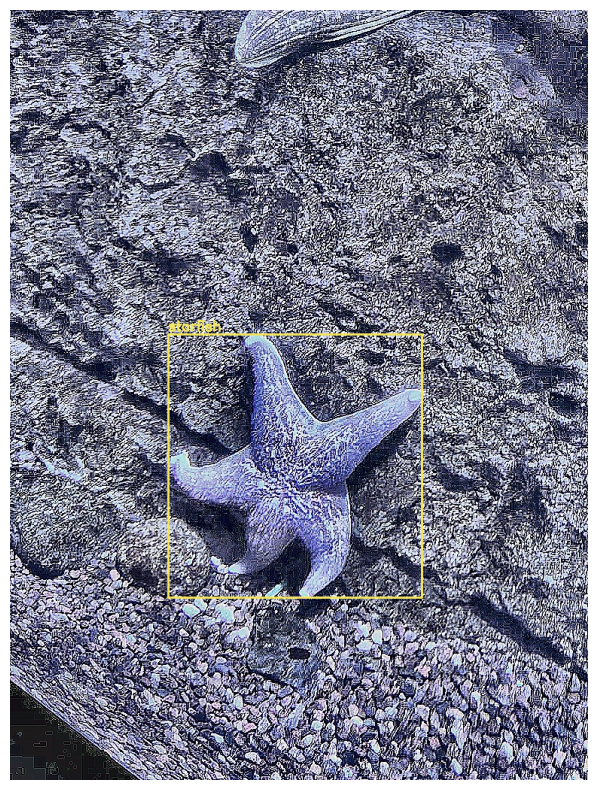

In [2]:
import cv2
import os
import random
import matplotlib.pyplot as plt

# YOLO class names
class_names = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

# Random color for each class
colors = {i: [random.randint(0, 255) for _ in range(3)] for i in range(len(class_names))}

def draw_yolo_boxes(image_path, label_path, save_path=None):
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            cls = int(parts[0])
            x, y, bw, bh = map(float, parts[1:5])

            x1 = int((x - bw/2) * w)
            y1 = int((y - bh/2) * h)
            x2 = int((x + bw/2) * w)
            y2 = int((y + bh/2) * h)

            color = colors[cls]
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, class_names[cls], (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    if save_path:
        cv2.imwrite(save_path, img)

    # Show image in notebook
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    return img


image_path = "data/images/test/IMG_2387_jpeg_jpg.rf.09b38bacfab0922a3a6b66480f01b719_aug_1.jpg" 
label_path = "data/labels/test/IMG_2387_jpeg_jpg.rf.09b38bacfab0922a3a6b66480f01b719_aug_1.txt" 
save_path = "output.jpg" 

draw_yolo_boxes(image_path, label_path, save_path="output.jpg")


# Separate Penguin and Puffin Images

In [2]:
import os
import shutil
import cv2

# ---------------------------
# CONFIG
# ---------------------------
DATA_DIRS = {
    "train": "data/aquarium_pretrain/train",
    "valid": "data/aquarium_pretrain/valid",
    "test":  "data/aquarium_pretrain/test"
}

CLASS_NAME = "puffin"  # class to filter
CLASSES = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

OUTPUT_DIR = "puffin_dataset"

# Create subfolders
for split in ["train", "valid", "test"]:
    os.makedirs(os.path.join(OUTPUT_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split, "labels"), exist_ok=True)

# ---------------------------
# CHECK IF IMAGE CONTAINS TARGET CLASS
# ---------------------------
def contains_class(label_path, target_cls_id):
    if not os.path.exists(label_path):
        return False
    with open(label_path, "r") as f:
        for line in f:
            cls_id = int(line.strip().split()[0])
            if cls_id == target_cls_id:
                return True
    return False

# ---------------------------
# PROCESS EACH SPLIT
# ---------------------------
target_cls_id = CLASSES.index(CLASS_NAME)

for split_name, dataset_path in DATA_DIRS.items():
    img_folder = os.path.join(dataset_path, "images")
    label_folder = os.path.join(dataset_path, "labels")

    out_img_dir   = os.path.join(OUTPUT_DIR, split_name, "images")
    out_label_dir = os.path.join(OUTPUT_DIR, split_name, "labels")

    for img_name in os.listdir(img_folder):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        label_name = img_name.rsplit(".", 1)[0] + ".txt"
        img_path = os.path.join(img_folder, img_name)
        label_path = os.path.join(label_folder, label_name)

        # Check if contains the chosen class
        if contains_class(label_path, target_cls_id):

            # ❌ Save original image (NO bounding boxes)
            shutil.copy(img_path, os.path.join(out_img_dir, img_name))

            # Copy label file
            shutil.copy(label_path, os.path.join(out_label_dir, label_name))

print(f"Done! All '{CLASS_NAME}' images copied (without boxes, split by train/valid/test) into '{OUTPUT_DIR}'")


Done! All 'puffin' images copied (without boxes, split by train/valid/test) into 'puffin_dataset'


In [2]:
import os
import cv2
import random
import shutil
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from tqdm import tqdm
import numpy as np

# ================================
# 🔥 SUBTLE CUSTOM TRANSFORMS
# ================================

class SubtleDehaze(ImageOnlyTransform):
    def __init__(self, intensity_range=(0.3, 0.7), p=0.5):
        super().__init__(p=p)
        self.intensity_range = intensity_range
        
    def apply(self, img, **params):
        intensity = random.uniform(*self.intensity_range)
        
        # Convert to LAB color space
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        
        # Gentle CLAHE
        clip_limit = 1.5 + intensity * 1.0  # Reduced from 2.0
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
        l_enhanced = clahe.apply(l)
        
        # More conservative blending
        l_final = cv2.addWeighted(l_enhanced, intensity * 0.7, l, 1 - (intensity * 0.7), 0)
        lab = cv2.merge((l_final, a, b))
        dehazed = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        return dehazed

class GentleColorJitter(ImageOnlyTransform):
    def __init__(self, p=0.5):
        super().__init__(p=p)
        
    def apply(self, img, **params):
        # More subtle color variations
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)
        
        # Reduced hue variation
        h_shift = random.randint(-5, 5)  # Reduced from ±10
        h = (h.astype(np.int16) + h_shift) % 180
        h = h.astype(np.uint8)
        
        # Reduced saturation and value variations
        s = cv2.multiply(s, random.uniform(0.8, 1.2))  # Reduced range
        v = cv2.multiply(v, random.uniform(0.8, 1.2))  # Reduced range
        
        hsv = cv2.merge([h, s, v])
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

class SubtleNoise(ImageOnlyTransform):
    def __init__(self, p=0.3):
        super().__init__(p=p)
        
    def apply(self, img, **params):
        noise_type = random.choice(['gaussian', 'speckle'])  # Removed salt_pepper
        
        if noise_type == 'gaussian':
            row, col, ch = img.shape
            mean = 0
            var = random.uniform(0.001, 0.005)  # Reduced variance
            sigma = var ** 0.5
            gauss = np.random.normal(mean, sigma, (row, col, ch))
            noisy = img + gauss * 255
            return np.clip(noisy, 0, 255).astype(np.uint8)
            
        else:  # speckle
            row, col, ch = img.shape
            gauss = np.random.randn(row, col, ch) * random.uniform(0.05, 0.1)  # Reduced
            noisy = img + img * gauss
            return np.clip(noisy, 0, 255).astype(np.uint8)

class GentleSharpening(ImageOnlyTransform):
    def __init__(self, p=0.4):
        super().__init__(p=p)
        
    def apply(self, img, **params):
        # Only use light and medium sharpening
        kernel_type = random.choice(['medium', 'light'])  # Removed 'strong'
        
        if kernel_type == 'medium':
            kernel = np.array([[0, -0.7, 0],      # Reduced from -1
                              [-0.7, 4.4, -0.7],  # Reduced from 5
                              [0, -0.7, 0]])
        else:  # light
            kernel = np.array([[0, -0.3, 0],
                              [-0.3, 2.6, -0.3],
                              [0, -0.3, 0]])
            
        sharpened = cv2.filter2D(img, -1, kernel)
        return np.clip(sharpened, 0, 255).astype(np.uint8)

# ================================
# 🔧 CONFIG
# ================================

image_dir = "penguin_dataset/valid/images"
label_dir = "penguin_dataset/valid/labels"

output_image_dir = "penguin_dataset/valid_aug/images"
output_label_dir = "penguin_dataset/valid_aug/labels"

num_aug_per_image = 6

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

# ================================
# ✨ BALANCED AUGMENTATION PIPELINE
# ================================

transform = A.Compose([
    # Color and contrast transformations (reduced intensity)
    A.OneOf([
        GentleColorJitter(p=1.0),
        A.ColorJitter(
            brightness=0.2,    # Reduced from 0.4
            contrast=0.2,      # Reduced from 0.4
            saturation=0.2,    # Reduced from 0.4
            hue=0.05,          # Reduced from 0.1
            p=1.0
        ),
    ], p=0.6),  # Reduced probability from 0.8
    
    # Dehazing and clarity (more subtle)
    A.OneOf([
        SubtleDehaze(intensity_range=(0.2, 0.6), p=1.0),  # Reduced intensity
        A.CLAHE(clip_limit=2.0, p=1.0),  # Reduced from 4.0
        A.RandomGamma(gamma_limit=(80, 120), p=1.0),  # Narrower range
    ], p=0.5),  # Reduced probability from 0.7
    
    # Sharpening and blurring (gentler)
    A.OneOf([
        GentleSharpening(p=1.0),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.8, 1.0), p=1.0),  # Reduced alpha
        A.GaussianBlur(blur_limit=(3, 5), p=0.5),  # Removed MotionBlur
    ], p=0.4),  # Reduced probability from 0.6
    
    # Noise and compression (subtle)
    A.OneOf([
        SubtleNoise(p=1.0),
        A.GaussNoise(var_limit=(10, 30), p=1.0),  # Reduced variance
        A.ISONoise(color_shift=(0.01, 0.03), intensity=(0.1, 0.3), p=1.0),  # Reduced
        A.ImageCompression(quality_lower=60, quality_upper=90, p=1.0),  # Less compression
    ], p=0.3),  # Reduced probability from 0.5
    
    # REMOVED: RandomFog (causes white smoke), RandomShadow, ChannelShuffle
    
    # Advanced brightness/contrast (subtle)
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=1.0),
    ], p=0.4),  # Reduced probability
    
    # Quality adjustments (subtle)
    A.OneOf([
        A.Downscale(scale_min=0.7, scale_max=0.9, p=0.3),  # Less downscaling
        A.MultiplicativeNoise(multiplier=(0.95, 1.05), p=0.3),  # Reduced range
    ], p=0.2),  # Reduced probability
    
    # Add subtle enhancements that preserve image quality
    A.OneOf([
        A.MedianBlur(blur_limit=3, p=0.3),
        A.ToGray(p=0.1),  # Occasional grayscale for robustness
    ], p=0.2),
])

# ================================
# 🚀 PROCESSING FUNCTION
# ================================

valid_exts = {".jpg", ".jpeg", ".png"}
images = [f for f in os.listdir(image_dir) if os.path.splitext(f)[1].lower() in valid_exts]

print(f"Found {len(images)} images")

for img_name in tqdm(images, desc="Augmenting"):
    img_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")

    if not os.path.exists(label_path):
        continue

    image = cv2.imread(img_path)
    if image is None:
        continue
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Save original
    shutil.copy(img_path, os.path.join(output_image_dir, img_name))
    shutil.copy(label_path, os.path.join(output_label_dir, os.path.splitext(img_name)[0] + ".txt"))

    # Create augmentations
    base = os.path.splitext(img_name)[0]
    
    for i in range(num_aug_per_image):
        try:
            augmented = transform(image=image)
            aug_img = augmented["image"]
            
            aug_name = f"{base}_aug_{i}.jpg"
            aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(output_image_dir, aug_name), aug_img_bgr, 
                       [cv2.IMWRITE_JPEG_QUALITY, 95])  # Better quality
            shutil.copy(label_path, os.path.join(output_label_dir, base + f"_aug_{i}.txt"))
        except Exception as e:
            print(f"Error augmenting {img_name}: {e}")
            continue

print("\n✅ Balanced augmentation completed successfully!")
print(f"Augmented images saved to: {output_image_dir}")
print(f"Labels saved to: {output_label_dir}")

/tmp/ipykernel_1992426/4160793923.py:150: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 30), p=1.0),  # Reduced variance
/tmp/ipykernel_1992426/4160793923.py:152: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=90, p=1.0),  # Less compression
/tmp/ipykernel_1992426/4160793923.py:165: UserWarning: Argument(s) 'scale_min, scale_max' are not valid for transform Downscale
  A.Downscale(scale_min=0.7, scale_max=0.9, p=0.3),  # Less downscaling


Found 10 images


Augmenting: 100%|██████████| 10/10 [00:00<00:00, 11.21it/s]


✅ Balanced augmentation completed successfully!
Augmented images saved to: penguin_dataset/valid_aug/images
Labels saved to: penguin_dataset/valid_aug/labels


# Data Split

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
from collections import defaultdict

# ------------------------------------------------------
# CONFIG
# ------------------------------------------------------
IMG_DIR = "new_data/images"
LBL_DIR = "new_data/labels"

TRAIN_RATIO = 0.80
VAL_RATIO   = 0.10
TEST_RATIO  = 0.10

# ------------------------------------------------------
# Create output folders
# ------------------------------------------------------
for sub in ["train", "val", "test"]:
    os.makedirs(os.path.join(IMG_DIR, sub), exist_ok=True)
    os.makedirs(os.path.join(LBL_DIR, sub), exist_ok=True)

# ------------------------------------------------------
# Helper: copy image + label
# ------------------------------------------------------
def copy_pair(img_path, lbl_path, split):
    shutil.copy(img_path, os.path.join(IMG_DIR, split))
    shutil.copy(lbl_path, os.path.join(LBL_DIR, split))

# ------------------------------------------------------
# Group images by class ID
# ------------------------------------------------------
class_to_files = defaultdict(list)

for lbl_file in os.listdir(LBL_DIR):
    if not lbl_file.endswith(".txt"):
        continue

    lbl_path = os.path.join(LBL_DIR, lbl_file)
    img_jpg = os.path.join(IMG_DIR, lbl_file.replace(".txt", ".jpg"))
    img_png = os.path.join(IMG_DIR, lbl_file.replace(".txt", ".png"))
    img_path = img_jpg if os.path.exists(img_jpg) else img_png

    if not os.path.exists(img_path):
        print("Missing image for:", lbl_file)
        continue

    with open(lbl_path, "r") as f:
        lines = f.readlines()

    class_ids = [int(line.split()[0]) for line in lines]
    majority_class = max(set(class_ids), key=class_ids.count)

    class_to_files[majority_class].append((img_path, lbl_path))

# ------------------------------------------------------
# STRATIFIED SPLIT
# ------------------------------------------------------
for cls, items in class_to_files.items():
    total = len(items)
    print(f"Class {cls}: {total} samples")

    # -------------------------------
    # Case 1: Only 1 sample
    # -------------------------------
    if total == 1:
        print(" → Only 1 sample → Putting into TRAIN")
        copy_pair(items[0][0], items[0][1], "train")
        continue

    # -------------------------------
    # Case 2: 2 samples
    # -------------------------------
    if total == 2:
        print(" → 2 samples → train + val")
        train_items, val_items = train_test_split(items, test_size=1, random_state=42)
        copy_pair(train_items[0][0], train_items[0][1], "train")
        copy_pair(val_items[0][0], val_items[0][1], "val")
        continue

    # -------------------------------
    # Case 3: 3 samples
    # -------------------------------
    if total == 3:
        print(" → 3 samples → train + val + test")
        train_item, temp_items = train_test_split(items, test_size=2, random_state=42)
        val_item, test_item = train_test_split(temp_items, test_size=1, random_state=42)

        copy_pair(train_item[0][0], train_item[0][1], "train")
        copy_pair(val_item[0][0], val_item[0][1], "val")
        copy_pair(test_item[0][0], test_item[0][1], "test")
        continue

    # -------------------------------
    # Case 4: Normal stratified split (4+ samples)
    # -------------------------------
    train_items, temp_items = train_test_split(
        items,
        test_size=(1 - TRAIN_RATIO),
        shuffle=True,
        random_state=42
    )

    val_items, test_items = train_test_split(
        temp_items,
        test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
        shuffle=True,
        random_state=42
    )

    print(f" → train: {len(train_items)}, val: {len(val_items)}, test: {len(test_items)}")

    # save files
    for img, lbl in train_items:
        copy_pair(img, lbl, "train")
    for img, lbl in val_items:
        copy_pair(img, lbl, "val")
    for img, lbl in test_items:
        copy_pair(img, lbl, "test")

print("\n✔ DONE — Dataset split successfully.\n")

Class 0: 80 samples
 → train: 64, val: 8, test: 8
Class 2: 97 samples
 → train: 77, val: 10, test: 10
Class 4: 119 samples
 → train: 95, val: 12, test: 12
Class 3: 21 samples
 → train: 16, val: 2, test: 3
Class 6: 1 samples
 → Only 1 sample → Putting into TRAIN
Class 5: 1 samples
 → Only 1 sample → Putting into TRAIN
Class 1: 1 samples
 → Only 1 sample → Putting into TRAIN

✔ DONE — Dataset split successfully.

